[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds-reboot/python-first-part/blob/main/notebooks/hometasks/Task2_dmrf_visual.ipynb)

# Задание
* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить результаты в pandas dataframe
<hr>

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:
-- Привести колонки датафрейма к одному типу данных
-- Проверить индекс, чтобы он соответствовал порядку строк
-- Проверить наличие пропусков и в случае обнаружения, определить стратегию их обработки
<hr>

* Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.
-- Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены.
-- Рассчитать объемы вводимого жилья по регионам и по годам.
-- Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах
-- Визуализировать разброс, связь и распределение этих показателей по регионам
-- Сделать выводы по каждому из расчетов и графиков



In [45]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

## Загрузка ранее сохраненного ДФ

In [46]:
conn = sqlite3.connect('data/test_database.db')
df = pd.read_sql('SELECT * FROM real_estate', conn,
                 parse_dates=['objReady100PercDt','developer.orgBankruptMsgDttm'])
conn.commit()
conn.close()

# Преобразования ДФ

In [47]:
'''
Переименовываем колонки, т.к. текущее название не всегда очевидно
'''
df = df.rename(columns={'objElemLivingCnt' : 'flat_count',
                        'objReady100PercDt': 'date_obj_ready',
                        'wallMaterialShortDesc' : 'wall_material',
                        'objLkFinishTypeDesc': 'flat_finish_type',
                        'objLkFreePlanDesc' : 'free_plan',
                        'objElemParkingCnt' : 'parking_count',
                        'objLkClassDesc' : 'class',
                        'objFlatSq' : 'flat_square',
                        'objInfrstrBicycleLaneFlg' : 'bicycle_lane',
                        'objInfrstrRampFlg' : 'ramp_for_disabled',
                        'objInfrstrCurbLoweringFlg' : 'lowering_for_disabled',
                        'nonlivFirstFloor' : 'first_floor_commercial',
                        'developer.devId' : 'developer_id',
                        'objReadyDesc' : 'ready_status',
                        'quartography.objLivElemEntrFloorAvg' : 'avg_flat_on_floor',
                        'quartography.objLivElemEntrCnt' : 'entrance_count',
                        'quartography.objLivElemCnt' : 'total_flat',
                        'quartography.objLivElem1KCnt' : 'total_1k',
                        'quartography.objLivElem2KCnt' : 'total_2k',
                        'quartography.objLivElem3KCnt' : 'total_3k',
                        'quartography.objLivElem4KCnt' : 'total_4k',
                        'objLivCeilingHeight' : 'ceiling_height',
                        'developer.problObjCnt' : 'developer_problem_obj',
                        'developer.regRegionDesc' : 'developer_region',
                        'developer.bankruptStage.bankruptStageDesc' : 'developer_bankrupt_stage',
                        'developer.orgBankruptMsgDttm' : 'developer_bankrupt_date',
                        'residentialBuildings' : 'build_type',
                        'objInfrstrPlaygrndCnt' : 'playground',
                        'objInfrstrSportGroundCnt' : 'sportground',
                        'objInfrstrTrashAreaCnt' : 'trash_area',
                        'objInfrstrObjPrkngCnt' : 'guest_parking_on_territory',
                        'objInfrstrNotObjPrkngCnt' : 'guest_parking_outside',
                        'objElevatorWheelchairCnt' : 'wheelchair_elevator',
                        'objElevatorPassengerCnt' : 'passenger_elevator',
                        'objElevatorCargoCnt' : 'cargo_elevator',
                        'developer.devShortNm' : 'developer_name'
                        })

In [48]:
"""
Оставляем только полезные, на первый взгляд, столбцы, и столбцы информация в которых не дублируется
"""
df = df[['id', 'region', 'floorMin', 'floorMax', 'flat_count', 'ready_status',
         'date_obj_ready', 'build_type', 'wall_material', 'flat_finish_type',
         'free_plan', 'parking_count', 'class', 'flat_square',
         'bicycle_lane', 'ramp_for_disabled', 'lowering_for_disabled',
         'first_floor_commercial', 'developer_id', 'developer_name', 'developer_problem_obj',
         'developer_region','objPriceAvg','total_1k', 'total_2k', 'total_3k', 'total_4k',
         'total_flat', 'entrance_count', 'avg_flat_on_floor', 'ceiling_height',
         'playground', 'sportground', 'trash_area', 'guest_parking_on_territory',
         'guest_parking_outside', 'wheelchair_elevator', 'passenger_elevator',
         'cargo_elevator', 'developer_bankrupt_stage', 'developer_bankrupt_date',
         ]]

In [49]:
"""
Смотрим получившуюся структуру данных. Столбцы 50, 51 оставим,
т.к. там содержится информация о банкротствах
И сбросим индекс строк, на всякий случай
"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30532 entries, 0 to 30531
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          30532 non-null  float64       
 1   region                      30532 non-null  float64       
 2   floorMin                    30097 non-null  float64       
 3   floorMax                    30173 non-null  float64       
 4   flat_count                  30518 non-null  float64       
 5   ready_status                27602 non-null  object        
 6   date_obj_ready              30521 non-null  datetime64[ns]
 7   build_type                  30532 non-null  float64       
 8   wall_material               30532 non-null  object        
 9   flat_finish_type            30532 non-null  object        
 10  free_plan                   29538 non-null  object        
 11  parking_count               30499 non-null  float64   

In [50]:
df.reset_index(drop=True, inplace=True)

In [51]:
"""
Далее преобразуем float в int для тех колонок, в которых не предусмотрено
дробных значений. Преобразовались не все, но для работы достаточно.
flat_square преобразуем в float
"""

df.flat_square = df.flat_square.apply(float)
for i in df:
    if i not in ['ready_status', 'date_obj_ready', 'wall_material',
             'flat_finish_type', 'free_plan', 'class', 'flat_square',
             'objEnergyEffShortDesc', 'infrastructureIndexValue',
             'developer_region', 'developer_group', 'soldOutPerc', 'objPriceAvg', 'ceiling_height',
             'developer_bankrupt_stage', 'developer_bankrupt_date', 'developer_name']:
        df[[i]] = df[[i]].applymap(int, na_action='ignore')

# Анализ ДФ. Информация по проблемным застройщикам и количество банкротств

In [52]:
'''
Выберем застройщиков, которые имеют проблемные недостроенные объекты
(фонды, которые занимаются достройкой объектов исключаем)
'''

search_fund = df['developer_problem_obj'][df['developer_name'].str.contains(r".*ФОНД.*") == False]
search_fund2 = df['developer_problem_obj'][df['developer_name'].str.contains(r".*ЗАЩИТЫ.*") == False]
problem_developer = df[['developer_name', 'developer_problem_obj']]\
    [(df.developer_problem_obj > 1) & search_fund & search_fund2]\
    .sort_values('developer_problem_obj', ascending=False)

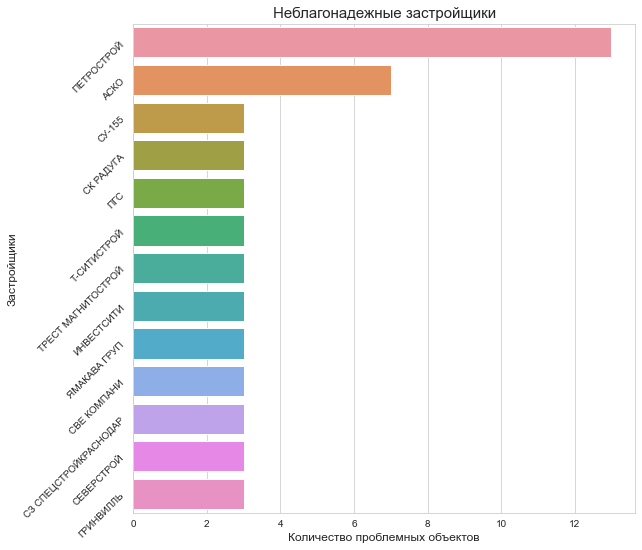

In [53]:
'''
Возглавляют рейтинг: ПЕТРОСТРОЙ и АСКО.
Остальные застройщики имеют по 3 недостроенных объекта
'''
plt.figure(figsize=(9, 9))
pl = sns.barplot(data=problem_developer,
                x='developer_problem_obj', y='developer_name')
pl.yaxis.set_tick_params(rotation=45)
pl.set_ylabel('Застройщики', fontsize=12)
pl.set_xlabel('Количество проблемных объектов', fontsize=12)
plt.title('Неблагонадежные застройщики',fontsize=15)
plt.show()

In [54]:
"""
Теперь выведем наиболее эффективные фонды
"""
search_fund = df['developer_problem_obj'][df['developer_name'].str.contains(r".*ФОНД.*")]
search_fund2 = df['developer_problem_obj'][df['developer_name'].str.contains(r".*ЗАЩ.*")]
best_fund = df[['developer_name', 'developer_problem_obj']]\
    [(df.developer_problem_obj > 1) &  search_fund | search_fund2]\
    .sort_values('developer_problem_obj', ascending=False)
best_fund.developer_name.unique()[:3]

array(['ФОНД ЛО', 'ФОНД ЗАЩИТЫ ПРАВ ДОЛЬЩИКОВ КУБАНИ',
       'ФОНД ЗАЩИТЫ ПРАВ ГРАЖДАН-УЧАСТНИКОВ СТРОИТЕЛЬСТВА ПК'],
      dtype=object)

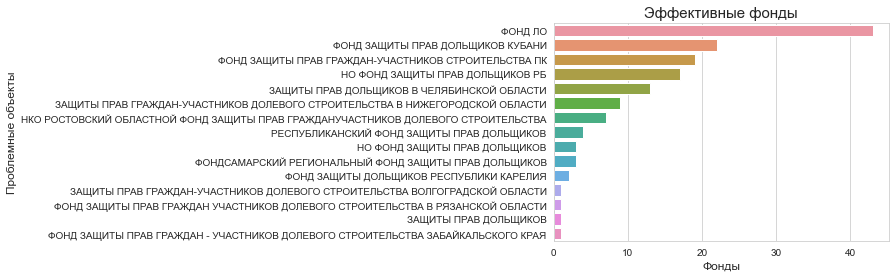

In [55]:
"""
Наиболее эффективным фондом, с большим отрывом, является фонд ЛО
"""
pl = sns.barplot(data=best_fund,
                x='developer_problem_obj', y='developer_name')
pl.set_ylabel('Проблемные объекты', fontsize=12)
pl.set_xlabel('Фонды', fontsize=12)
plt.title('Эффективные фонды',fontsize=15)
plt.show()

In [56]:
"""
Проанализируем количество банкротств информация по которым загружена с 2014 года
"""
bankrupts = df.copy()
bankrupts['year_of_bankrupt'] = pd.DatetimeIndex(bankrupts.developer_bankrupt_date).year
bankrupts = bankrupts[bankrupts['year_of_bankrupt'] > 1900].groupby('year_of_bankrupt', as_index=False)\
                                                .agg({'developer_id' : 'count'})\
                                                .rename(columns={'developer_id' : 'count_of_bankrupts'})
bankrupts.sort_values('count_of_bankrupts', ascending=False).head(3)

,year_of_bankrupt,count_of_bankrupts
6,2020.0,176
5,2019.0,123
4,2018.0,117


In [57]:
(bankrupts.sort_values('count_of_bankrupts', ascending=False).count_of_bankrupts.iloc[3]/\
bankrupts.sort_values('count_of_bankrupts', ascending=False).count_of_bankrupts.iloc[4] - 1) * 100

15.384615384615374

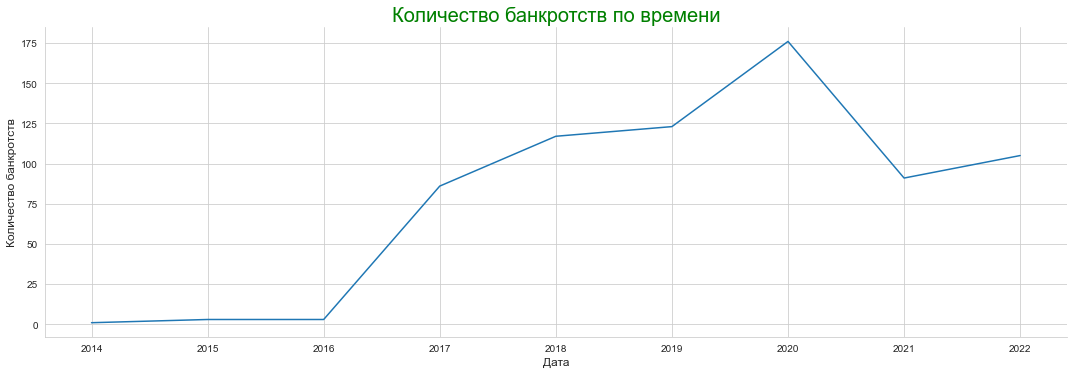

In [58]:
pl = sns.relplot(
    x='year_of_bankrupt',
    y='count_of_bankrupts',
    data=bankrupts,
    kind='line',
    aspect=3
)
plt.title('Количество банкротств по времени', size=20, color='g')
pl.set_ylabels('Количество банкротств', fontsize=12)
pl.set_xlabels('Дата', fontsize=12)
plt.show()

Исходя из представленного графика видно, что с 2014 года наблюдается рост числа банкротств.
Пик приходится на 2020 год.
Не смотря на то, что 2022 год еще не завершился, количество банкроств уже более чем на 15% превышает показатели 2021 года

In [59]:
df[df.developer_bankrupt_date > '1900-01-01'].groupby('region', as_index=False)\
                        .agg({'id' : 'count'})\
                        .rename(columns={'id': 'count_of_bankrupts'})\
                        .sort_values('count_of_bankrupts', ascending=False).head(3)

,region,count_of_bankrupts
32,50,151
52,77,82
31,47,82


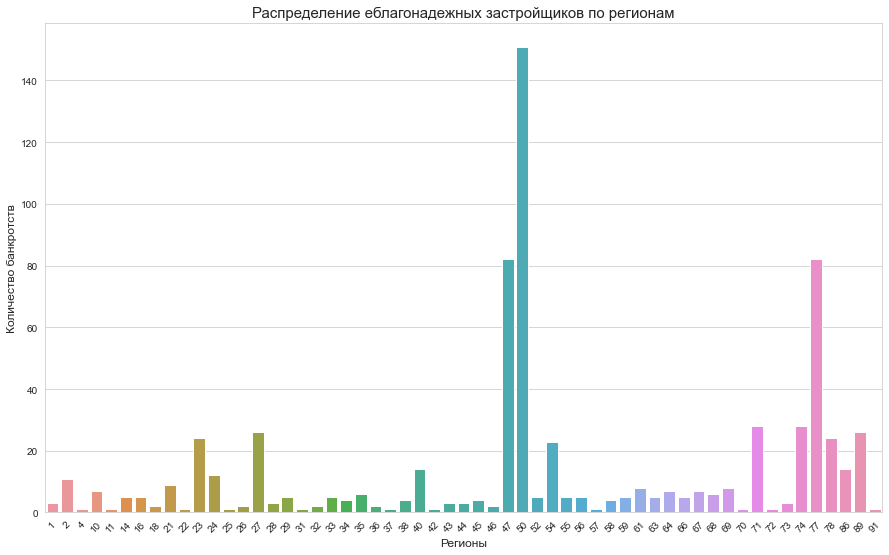

In [60]:
plt.figure(figsize=(15, 9))
pl = sns.barplot(data=df[df.developer_bankrupt_date > '1900-01-01'].groupby('region', as_index=False)\
                        .agg({'id' : 'count'})\
                        .rename(columns={'id': 'count_of_bankrupts'}),
                x='region', y='count_of_bankrupts')
pl.xaxis.set_tick_params(rotation=45)
pl.set_ylabel('Количество банкротств', fontsize=12)
pl.set_xlabel('Регионы', fontsize=12)
plt.title('Распределение еблагонадежных застройщиков по регионам',fontsize=15)
plt.show()

В антилидерах по количеству проблемных застройщиков Московская область, Ленинградская область и Москва

# Информация по объектам

In [61]:
df.head()

,id,region,floorMin,floorMax,flat_count,ready_status,date_obj_ready,build_type,wall_material,flat_finish_type,...,playground,sportground,trash_area,guest_parking_on_territory,guest_parking_outside,wheelchair_elevator,passenger_elevator,cargo_elevator,developer_bankrupt_stage,developer_bankrupt_date
0,7,77,21.0,21.0,0.0,Сдан,2019-04-09,0,Другое,Другое,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaT
1,8,77,2.0,15.0,1553.0,Сдан,2019-12-12,1,Панель,По желанию заказчика,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaT
2,9,50,NaN,NaN,108.0,Сдан,2018-12-14,1,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaT
3,10,77,NaN,NaN,1376.0,Сдан,2019-03-25,1,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaT
4,11,77,NaN,NaN,709.0,Сдан,2018-12-12,1,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaT


In [62]:
grouped_region = df.groupby(['region'], as_index=False).agg({
    'id' : 'count', 'objPriceAvg' : 'mean', 'flat_square' : 'mean'
}).rename(columns={'objPriceAvg' : 'price_avg_group', 'id' : 'count_of_flats'})\
    .sort_values('price_avg_group', ascending=False)

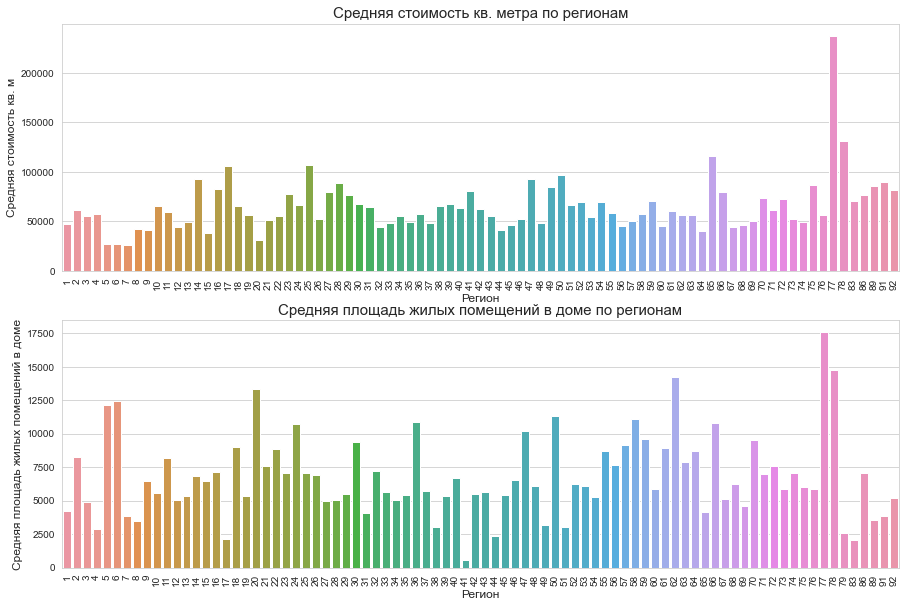

In [63]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(15, 10))
ax1, ax2 = ax


sns.barplot(data=grouped_region.dropna(),
                x='region', y='price_avg_group', ax=ax1)


sns.barplot(data=grouped_region,
                x='region', y='flat_square', ax=ax2)


ax1.set_ylabel('Средняя стоимость кв. м', fontsize=12)
ax1.set_xlabel('Регион', fontsize=12)
ax1.set_title('Средняя стоимость кв. метра по регионам', fontsize=15)
ax1.xaxis.set_tick_params(rotation=90)

ax2.set_ylabel('Средняя площадь жилых помещений в доме', fontsize=12)
ax2.set_xlabel('Регион', fontsize=12)
ax2.set_title('Средняя площадь жилых помещений в доме по регионам', fontsize=15)
ax2.xaxis.set_tick_params(rotation=90)

plt.show()

По стоимости за 1 кв. м лидирует с большим отрывом Москва, далее идет СПБ и замыкает тройку лидеров Сахалинская область.
По средней площади ЖК первые 2 места не поменялись, на 3е место вышла Рязанская область и немного отстает Чечня

In [64]:
grouped_region.sort_values('flat_square', ascending=False).head(4)

,region,count_of_flats,price_avg_group,flat_square
76,77,2119,237404.684315,17582.009632
77,78,1722,131151.452481,14794.050557
61,62,193,57039.218978,14214.874922
19,20,28,30907.700000,13349.360714


In [65]:
grouped_region.head(3)

,region,count_of_flats,price_avg_group,flat_square
76,77,2119,237404.684315,17582.009632
77,78,1722,131151.452481,14794.050557
64,65,150,115853.759036,4157.562333


In [66]:
grouped_region = df.copy()
grouped_region['year_obj_ready'] = pd.DatetimeIndex(grouped_region.date_obj_ready).year
grouped_region = grouped_region.groupby(['year_obj_ready', 'region'], as_index=False)\
    .agg({'flat_square' : 'sum'}).rename(columns={'flat_square' : 'squre_in_region'})\
    .sort_values('squre_in_region', ascending=False)

In [67]:
grouped_region.year_obj_ready = grouped_region.year_obj_ready.apply(int)

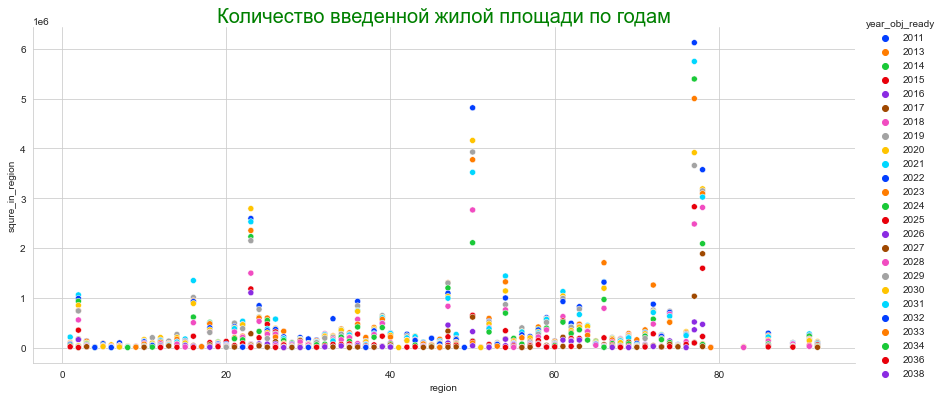

In [68]:
sns.relplot(
    x='region',
    y='squre_in_region',
    hue='year_obj_ready',
    aspect=2.2,
    height=5.5,
    palette="bright",
    legend='full',
    data=grouped_region[grouped_region.squre_in_region > 0])
plt.title('Количество введенной жилой площади по годам', size=20, color='g');

В соответствии с графиком, в среднем, больше всего площадей вводится в Москве, Московской области, СПб. 4-е место по объемам ввода занимает Краснодарский край.
Наиболее успешным годом для застройщиков и первой тройки регионов был 2011 год. В Краснодарском крае - это был 2020

# Посмотрим соотношение комнатности квартир в экономе и элит жилье на примере Москвы
(более наглядное сравнение, т.к. другие регионы нивелируют разницу)

In [69]:
"""
Создадим датасет, чтобы если еще что-то понадобится, обращаться к нему
"""
class_and_flats = df[['region', 'class', 'total_1k', 'total_2k', 'total_3k', 'total_4k', 'avg_flat_on_floor']].dropna()

In [70]:
"""
Сгруппируем значения по региону и классу
"""
class_and_region = class_and_flats.groupby(['region', 'class']).agg({'total_1k' : 'mean',
                                                  'total_2k' : 'mean',
                                                  'total_3k' : 'mean',
                                                  'total_4k' : 'mean',
                                                  'avg_flat_on_floor' : 'median'
                                                  })\
                    .rename(columns={'total_1k' : 'avg_1k',
                                     'total_2k' : 'avg_2k',
                                     'total_3k' : 'avg_3k',
                                     'total_4k' : 'avg_4k',
                                     'avg_flat_on_floor' : 'median_flat_on_floor'
                                     })
class_and_region.head()

avg_1k     avg_2k     avg_3k    avg_4k  \
region class                                                 
1      Бизнес   107.000000  55.666667  42.000000  2.000000   
       Другое    84.000000  14.000000   0.000000  0.000000   
       Комфорт  121.192308  55.884615   9.153846  0.230769   
       Типовой   65.240000  20.210000   4.160000  0.000000   
       Элитный   65.000000  39.000000  14.000000  0.000000   

                median_flat_on_floor  
region class                          
1      Бизнес                    8.0  
       Другое                   10.5  
       Комфорт                   8.5  
       Типовой                   8.0  
       Элитный                   5.0

In [71]:
"""
Преобразуем значения колонок в процентый вид
"""
for i in list(class_and_region)[:-1]:
    class_and_region[i] = (class_and_region[i] / (class_and_region.avg_1k\
                                                     + class_and_region.avg_2k\
                                                     + class_and_region.avg_3k\
                                                     + class_and_region.avg_4k)).mul(100).round(2)

In [72]:
"""
Сбросим индекс, чтобы обращаться к нему как к колонкам
"""
class_and_region = class_and_region.reset_index()

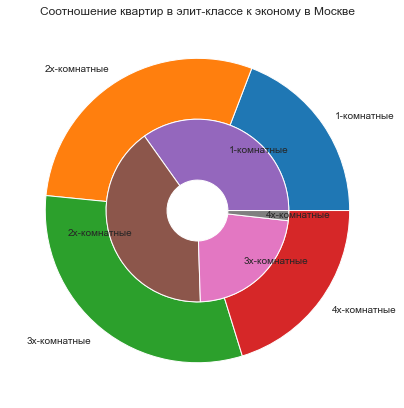

In [73]:
"""
Выгрузим значения по комнатности квартир в переменные и построим график
"""

avg_1k = class_and_region[(class_and_region.region == 77) & (class_and_region['class'] == "Элитный")]['avg_1k']
avg_2k = class_and_region[(class_and_region.region == 77) & (class_and_region['class'] == "Элитный")]['avg_2k']
avg_3k = class_and_region[(class_and_region.region == 77) & (class_and_region['class'] == "Элитный")]['avg_3k']
avg_4k = class_and_region[(class_and_region.region == 77) & (class_and_region['class'] == "Элитный")]['avg_4k']

avg_1kt = class_and_region[(class_and_region.region == 77) & (class_and_region['class'] == "Типовой")]['avg_1k']
avg_2kt = class_and_region[(class_and_region.region == 77) & (class_and_region['class'] == "Типовой")]['avg_2k']
avg_3kt = class_and_region[(class_and_region.region == 77) & (class_and_region['class'] == "Типовой")]['avg_3k']
avg_4kt = class_and_region[(class_and_region.region == 77) & (class_and_region['class'] == "Типовой")]['avg_4k']

v1 = [float(avg_1k), float(avg_2k), float(avg_3k), float(avg_4k)]
v2 = [float(avg_1kt), float(avg_2kt), float(avg_3kt), float(avg_4kt)]

labels = ["1-комнатные", "2х-комнатные", "3х-комнатные", "4х-комнатные"]

plt.figure(figsize=(7, 7))
width = 0.4
wedge_properties = {"width":width}
plt.pie(v1, labels=labels, wedgeprops=wedge_properties)
plt.pie(v2, labels=labels, labeldistance=0.75,
        radius=1-width, wedgeprops=wedge_properties)
plt.title("Соотношение квартир в элит-классе к эконому в Москве")
plt.show()

Как видим из графика есть разительное отличие в количестве 4х-комнатных квартир в элитном классе.
В типовом жилье преобладают однокомнатные квартиры, в то время как в элитном, однокомнатные квартиры занимают наименьшую долю.
Соотношение 2х- и 3х-комнатных квартир в элитном жилье примерно одинаковое.
В эконом жилье с повышением комнатности доля таких квартир падает. 4-х комнатных квартир ничтожно малое количество